In [1]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from keras import metrics
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint
import pprint
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
kdd_dataset = pd.read_csv('KDD.preProcessed.csv')
kdd_dataset.head()
#kdd_dataset.dropna()
np.random.seed(42)

In [3]:
columns = list(kdd_dataset)
features = columns
features.remove('label_DoS')
features.remove('label_Normal')
features.remove('label_Probe')
features.remove('label_R2L')
features.remove('label_U2R')

In [4]:

DoS = kdd_dataset.loc[kdd_dataset['label_DoS'] == 1]
Normal = kdd_dataset.loc[kdd_dataset['label_Normal'] == 1]
Probe = kdd_dataset.loc[kdd_dataset['label_Probe'] == 1]
R2L = kdd_dataset.loc[kdd_dataset['label_R2L'] == 1]
U2R = kdd_dataset.loc[kdd_dataset['label_U2R'] == 1]


In [5]:
DoS = DoS.sample(n=1000,random_state = 42)
Normal = Normal.sample(n=1000, random_state = 42)
Probe = Probe.sample(n=1000, random_state=42)
R2L = R2L.sample(n=1126, random_state=42)
'''
DoS = DoS.sample(n=100000,random_state = 42)
Normal = Normal.sample(n=100000, random_state = 42)
Probe = Probe.sample(n=40000, random_state=42)
R2L = R2L.sample(n=1126, random_state=42)
'''

'\nDoS = DoS.sample(n=100000,random_state = 42)\nNormal = Normal.sample(n=100000, random_state = 42)\nProbe = Probe.sample(n=40000, random_state=42)\nR2L = R2L.sample(n=1126, random_state=42)\n'

In [6]:
#U2R = U2R.append([U2R]*500,ignore_index=True)
#R2L = R2L.append([R2L]*100,ignore_index=True)
#DoS

In [7]:
reduced_dataset = pd.concat([DoS,Normal,Probe,R2L,U2R])
kdd_dataset = reduced_dataset.sample(n=len(reduced_dataset), random_state = 42)

In [8]:

x = kdd_dataset[features].values
y = kdd_dataset.iloc[:,53:].values
print("number of datapoints = {} and number of features = {}".format(len(x),len(x[0])))

number of datapoints = 4148 and number of features = 53


In [9]:
# Counting occurrences
from collections import Counter
print(Counter([tuple(x) for x in y]))

Counter({(0.0, 0.0, 0.0, 1.0, 0.0): 1126, (0.0, 0.0, 1.0, 0.0, 0.0): 1000, (0.0, 1.0, 0.0, 0.0, 0.0): 1000, (1.0, 0.0, 0.0, 0.0, 0.0): 1000, (0.0, 0.0, 0.0, 0.0, 1.0): 22})


In [10]:
#PCA

print("Shape before transformation - {}".format(np.asarray(x).shape))
pca = decomposition.PCA(n_components=10)
pca.fit(x)
x_pca = pca.transform(x)
print("Shape after transformation - {}".format(x_pca.shape))
x_pca = x_pca.tolist()



Shape before transformation - (4148, 53)
Shape after transformation - (4148, 10)


In [11]:
from sklearn.model_selection import train_test_split
X_tr, X_val, Y_tr, Y_val = train_test_split(x_pca, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tr, Y_tr,
                                                    stratify=Y_tr, 
                                                    test_size=0.25,
                                                    random_state=42)
max_len = len(X_train)

In [13]:
def processTrainTestArrays(x,y):
    x=np.asarray(x)
    y=np.asarray(y)
    
    x = np.reshape(x, (x.shape[0], x.shape[1],1))
    Y_temp = [[item]*10 for item in y]
    y = np.reshape(np.asarray(Y_temp),(x.shape[0]*10,5))
    #y = [[item]*10 for item in y]
    
    #y = [np.argmax(item) for item in y]
    #y = np.reshape(y, (y.shape[0], 1))


    return x,y

In [14]:
def onehotencode(y):
    #from keras.utils.np_utils import to_categorical
    #y_binary = to_categorical(y)
    y = [int(item) for item in y]
    targets = np.array(y).reshape(-1)
    y_binary = np.eye(5)[targets]
    
    return y_binary

In [15]:
# define model
#length = len(kdd_dataset)
def create_model(X_train,Y_train, number_of_units):
    Batch_size = 1
    randomInit = initializers.RandomUniform(seed=42)
    nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    
    model = Sequential()
    #model.add(LSTM(number_of_units, kernel_initializer = randomInit, bias_initializer = randomInit, stateful = True,
    #               batch_input_shape=(Batch_size,X_train.shape[1], X_train.shape[2]),return_sequences=True))
    model.add(LSTM(number_of_units, kernel_initializer = randomInit, bias_initializer = randomInit, stateful = True,
                   batch_input_shape=(Batch_size,1,1),return_sequences=False))
    
    #model.add(Dropout(0.1))
    #model.add(LSTM(number_of_units, kernel_initializer = randomInit, bias_initializer = randomInit, stateful = True,
    #               batch_input_shape=(Batch_size,X_train.shape[1], X_train.shape[2]),return_sequences=True))
    #model.add(Dropout(0.1))
    #model.add(LSTM(number_of_units, kernel_initializer = randomInit, bias_initializer = randomInit, stateful = True,
    #               batch_input_shape=(Batch_size,X_train.shape[1], X_train.shape[2])))
    #model.add(Dropout(0.1))
    model.add(Dense(Y_train.shape[1], activation='softmax'))
    
    nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    model.compile(loss='mean_squared_error', optimizer=nadam, metrics=['accuracy'])

    print(model.summary())
    return model

In [16]:
#model.summary()

In [17]:
def compute_metrics(predicted, Y_test):
   
    Y_classes = [np.argmax(item) for item in Y_test]
    #print(Y_classes)
    predicted_classes = [np.argmax(item) for item in predicted]
    
    predictions = np.array(predicted_classes)
    Y_actual = np.array(Y_classes)
   
    y_actu = pd.Series(np.reshape(Y_actual,len(Y_actual)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=[0,1,2,3,4])
    y_pre = pd.Categorical(y_pred, categories=[0,1,2,3,4])
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = [0,1,2,3,4])))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    predicted= np.array(predicted).tolist()
    Y_test = np.array(Y_test).tolist()

    n_classes = 5
    print("n_classes is: ", n_classes)
    Y_test= np.asarray(Y_test)
    predicted = np.asarray(predicted)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
     #Compute macro-average ROC curve and ROC area
    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
#checkpoint save weights
#Y_train

hdf5FileName = "bestWeightsLSTMStateful3L50.hdf5"
checkpoint = ModelCheckpoint(hdf5FileName,monitor='val_acc',verbose=1,save_best_only=True,mode='max',save_weights_only=True)

In [19]:
class ResetStatesCallback(Callback):
    def __init__(self):
        self.counter = 0

    def on_batch_begin(self, batch, logs={}):
        if self.counter % (max_len*10) == 0:
            self.model.reset_states()
            print("Model reset. ",self.counter)
            #self.counter = 0
        self.counter += 1
        #print(self.counter)
        

In [20]:
#Time to train

Batch_size=1
start_time = time.time()

x_train,y_train = processTrainTestArrays(X_train,Y_train)
x_val,y_val = processTrainTestArrays(X_val,Y_val)
model = create_model(x_train,y_train, 50)

x = np.expand_dims(np.expand_dims(x_train.flatten(), axis=1), axis=1)

x_val = np.expand_dims(np.expand_dims(x_val.flatten(), axis=1), axis=1)
model.fit(x, y_train, epochs=50, batch_size=Batch_size, verbose=1, shuffle=False,
            validation_data = (x_val,y_val),callbacks=[checkpoint,ResetStatesCallback()])


print("\n\n--- Time for training : %s seconds ---" % (time.time() - start_time))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 50)                   10400     
_________________________________________________________________
dense_1 (Dense)              (1, 5)                    255       
Total params: 10,655
Trainable params: 10,655
Non-trainable params: 0
_________________________________________________________________
None
Train on 24880 samples, validate on 8300 samples
Epoch 1/50
Model reset.  0
   19/24880 [..............................] - ETA: 14361s - loss: 0.1483 - acc: 0.5263   

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:97: UserWarning: Method on_batch_begin() is slow compared to the batch update (5.219173). Check your callbacks.
  % delta_t_median)


24880/24880 [==============================] - 262s - loss: 0.1343 - acc: 0.4340 - val_loss: 0.1098 - val_acc: 0.5475
Epoch 2/50
Model reset.  24880
24880/24880 [==============================] - 248s - loss: 0.1061 - acc: 0.5949 - val_loss: 0.1006 - val_acc: 0.6010
Epoch 3/50
Model reset.  49760
24880/24880 [==============================] - 248s - loss: 0.0824 - acc: 0.6948 - val_loss: 0.0704 - val_acc: 0.7418
Epoch 4/50
Model reset.  74640
24880/24880 [==============================] - 247s - loss: 0.0664 - acc: 0.7641 - val_loss: 0.0601 - val_acc: 0.7942
Epoch 5/50
Model reset.  99520
24880/24880 [==============================] - 247s - loss: 0.0605 - acc: 0.7881 - val_loss: 0.0561 - val_acc: 0.8028
Epoch 6/50
Model reset.  124400
24880/24880 [==============================] - 247s - loss: 0.0587 - acc: 0.7962 - val_loss: 0.0582 - val_acc: 0.7936
Epoch 7/50
Model reset.  149280
24880/24880 [==============================] - 245s - loss: 0.0574 - acc: 0.8002 - val_loss: 0.0576 - va


Time for testing

Optimal weights loaded from file bestWeightsLSTMStateful3L50.hdf5
Model Successfully compiled with loaded weights

8300/8300 [==============================] - 21s    
Loss for testing = 0.03811505821068982 and Accuracy for testing = 0.8734939759036144


/home/bwang/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average F1 score is 0.646220986703234
Confusion matrix: 
 Predicted    0    1    2   3
Actual                      
0          191    9    0   0
1            2  195    2   1
2            4   93  103   0
3            0    9  152  65
4            0    2    2   0
n_classes is:  5


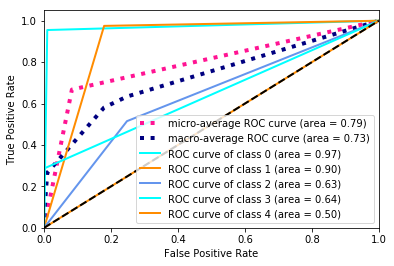

In [21]:
#Test with best model
#Load weights and compile again
print("\n===========================\nTime for testing\n===========================\n")
model.load_weights(hdf5FileName)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='mean_squared_error', optimizer=nadam, metrics=['accuracy'])
print("Optimal weights loaded from file {}".format(hdf5FileName))
print("Model Successfully compiled with loaded weights\n")

#Do same preprocessing for test data
x_test,y_test = processTrainTestArrays(X_test,Y_test)
x_test = np.expand_dims(np.expand_dims(x_test.flatten(), axis=1), axis=1)

loss,acc = model.evaluate(x_test,y_test,batch_size=Batch_size)
print("Loss for testing = {} and Accuracy for testing = {}".format(loss,acc))

predicted = model.predict(x_test,batch_size=Batch_size)

X_test = np.asarray(X_test)
temp = np.reshape(predicted,(Y_test.shape[0],X_test.shape[1],Y_test.shape[1]))
temp1 = [np.argmax(item1) for item in temp for item1 in item]
temp1 = np.reshape(np.asarray(temp1),(Y_test.shape[0],X_test.shape[1],1))
temp1 = [np.floor(np.mean(item)) for item in temp1]
temp1 = onehotencode(temp1)


compute_metrics(temp1, Y_test)    
